# Klasyfikator gestów oparty na CNN 1D
#### Model do rozpoznawania gestów magicznej różdżki na podstawie danych IMU (akcelerometr + żyroskop)

## 1. Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Wczytanie danych

In [2]:
def load_gesture_data(folder_path, gesture_name):
    """
    Wczytuje wszystkie pliki CSV z danego folderu
    Zwraca listę sekwencji (każda sekwencja to macierz [timesteps, 6_features])
    """
    files = glob.glob(os.path.join(folder_path, '*.csv'))
    sequences = []
    
    for file in files:
        df = pd.read_csv(file)
        # Usuwamy kolumnę time, zostawiamy tylko 6 cech IMU
        # acc_X, acc_Y, acc_Z, gyro_X, gyro_Y, gyro_Z
        features = df[['acc_X', 'acc_Y', 'acc_Z', 'gyro_X', 'gyro_Y', 'gyro_Z']].values
        sequences.append(features)
    
    print(f"{gesture_name}: {len(sequences)} próbek")
    return sequences

# Wczytaj dane dla każdego gestu
alohomora_data = load_gesture_data('alohomora_new', 'Alohomora')
lumos_data = load_gesture_data('lumos_new', 'Lumos')
wingardium_data = load_gesture_data('wingardium_new', 'Wingardium')
avada_data = load_gesture_data('avada_new', 'Avada')
mystery_data = load_gesture_data('mystery', 'Mystery')

Alohomora: 60 próbek
Lumos: 60 próbek
Wingardium: 60 próbek
Avada: 60 próbek
Mystery: 61 próbek


## 3. Analiza długości sekwencji

In [3]:
# Sprawdź długości sekwencji
all_lengths = []
for data, name in [(alohomora_data, 'Alohomora'), 
                    (lumos_data, 'Lumos'), 
                    (wingardium_data, 'Wingardium'), 
                    (avada_data, 'Avada'),
                    (mystery_data, 'Mystery')]:
    lengths = [len(seq) for seq in data]
    all_lengths.extend(lengths)
    print(f"{name}: min={min(lengths)}, max={max(lengths)}, avg={np.mean(lengths):.1f}")

print(f"\nWszystkie: min={min(all_lengths)}, max={max(all_lengths)}, avg={np.mean(all_lengths):.1f}")

# Ustalamy stałą długość sekwencji (weźmiemy 100 - jak w Arduino)
MAX_SEQUENCE_LENGTH = 100

Alohomora: min=163, max=314, avg=239.6
Lumos: min=93, max=328, avg=175.8
Wingardium: min=135, max=278, avg=200.1
Avada: min=127, max=313, avg=183.8
Mystery: min=230, max=375, avg=290.3

Wszystkie: min=93, max=375, avg=218.2


## 4. Preprocessing - padding i normalizacja

In [4]:
def pad_sequences(sequences, max_length):
    """
    Dopasowuje sekwencje do stałej długości
    - Jeśli za krótka: wypełnia zerami na końcu
    - Jeśli za długa: obcina do max_length
    """
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Padding zerami
            padding = np.zeros((max_length - len(seq), seq.shape[1]))
            padded_seq = np.vstack([seq, padding])
        else:
            # Obcinamy do max_length
            padded_seq = seq[:max_length]
        padded.append(padded_seq)
    return np.array(padded)

# Przygotowanie danych
X_alohomora = pad_sequences(alohomora_data, MAX_SEQUENCE_LENGTH)
X_lumos = pad_sequences(lumos_data, MAX_SEQUENCE_LENGTH)
X_wingardium = pad_sequences(wingardium_data, MAX_SEQUENCE_LENGTH)
X_avada = pad_sequences(avada_data, MAX_SEQUENCE_LENGTH)
X_mystery = pad_sequences(mystery_data, MAX_SEQUENCE_LENGTH)

# Łączymy wszystkie dane
X = np.vstack([X_alohomora, X_lumos, X_wingardium, X_avada, X_mystery])

# Etykiety (0: alohomora, 1: lumos, 2: wingardium, 3: avada, 4: mystery)
y_alohomora = np.zeros(len(X_alohomora), dtype=int)
y_lumos = np.ones(len(X_lumos), dtype=int)
y_wingardium = np.full(len(X_wingardium), 2, dtype=int)
y_avada = np.full(len(X_avada), 3, dtype=int)
y_mystery = np.full(len(X_mystery), 4, dtype=int)

y = np.concatenate([y_alohomora, y_lumos, y_wingardium, y_avada, y_mystery])

print(f"Kształt danych X: {X.shape}")  # (total_samples, 100, 6)
print(f"Kształt etykiet y: {y.shape}")  # (total_samples,)
print(f"Rozkład klas: {np.bincount(y)}")

Kształt danych X: (301, 100, 6)
Kształt etykiet y: (301,)
Rozkład klas: [60 60 60 60 61]


## 5. Podział na zbiór treningowy i testowy

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treningowy: {X_train.shape[0]} próbek")
print(f"Testowy: {X_test.shape[0]} próbek")

Treningowy: 240 próbek
Testowy: 61 próbek


## 6. Budowa modelu CNN 1D

In [6]:
def create_cnn_model(input_shape, num_classes):
    """
    CNN 1D zoptymalizowany dla microcontrollerów (Arduino Nano 33 BLE Sense)
    - Bardzo małe warstwy (aby zmieścić się w 1MB flash)
    - BatchNormalization dla stabilności
    - Dropout dla regularyzacji
    """
    model = keras.Sequential([
        # Pierwsza warstwa konwolucyjna (zmniejszono z 16 do 8)
        layers.Conv1D(8, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Druga warstwa konwolucyjna (zmniejszono z 32 do 16)
        layers.Conv1D(16, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Trzecia warstwa konwolucyjna (zmniejszono z 64 do 32)
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Flatten i warstwy gęste (zmniejszono rozmiary)
        layers.Flatten(),
        layers.Dense(32, activation='relu'),  # zmniejszono z 64 do 32
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),  # zmniejszono z 32 do 16
        layers.Dropout(0.2),
        
        # Warstwa wyjściowa
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Tworzenie modelu
model = create_cnn_model(input_shape=(MAX_SEQUENCE_LENGTH, 6), num_classes=5)
model.summary()

# Informacja o rozmiarze modelu
param_count = model.count_params()
print(f"\nLiczba parametrów: {param_count:,}")
print(f"Przybliżony rozmiar (float32): ~{param_count * 4 / 1024:.1f} KB")

c:\Users\Olek\.platformio\penv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 8)          │           248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,581 (53.05 KB)

 Trainable params: 13,469 (52.61 KB)

 Non-trainable params: 112 (448.00 B)


Liczba parametrów: 13,581
Przybliżony rozmiar (float32): ~53.1 KB


## 7. Kompilacja i trening

In [7]:
# Kompilacja
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Trening
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2031 - loss: 2.4850 - val_accuracy: 0.3125 - val_loss: 2.1725 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2656 - loss: 1.9483 - val_accuracy: 0.4167 - val_loss: 1.6117 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2969 - loss: 1.7609 - val_accuracy: 0.4583 - val_loss: 1.4910 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3594 - loss: 1.5625 - val_accuracy: 0.5417 - val_loss: 1.4567 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4479 - loss: 1.3407 - val_accuracy: 0.6042 - val_loss: 1.3961 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4427 - loss: 1.3103 - val_accuracy: 0.6667 - val_loss: 1.3355 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5417 - loss: 1.2111 - val_accuracy: 

## 8. Wizualizacja wyników treningu

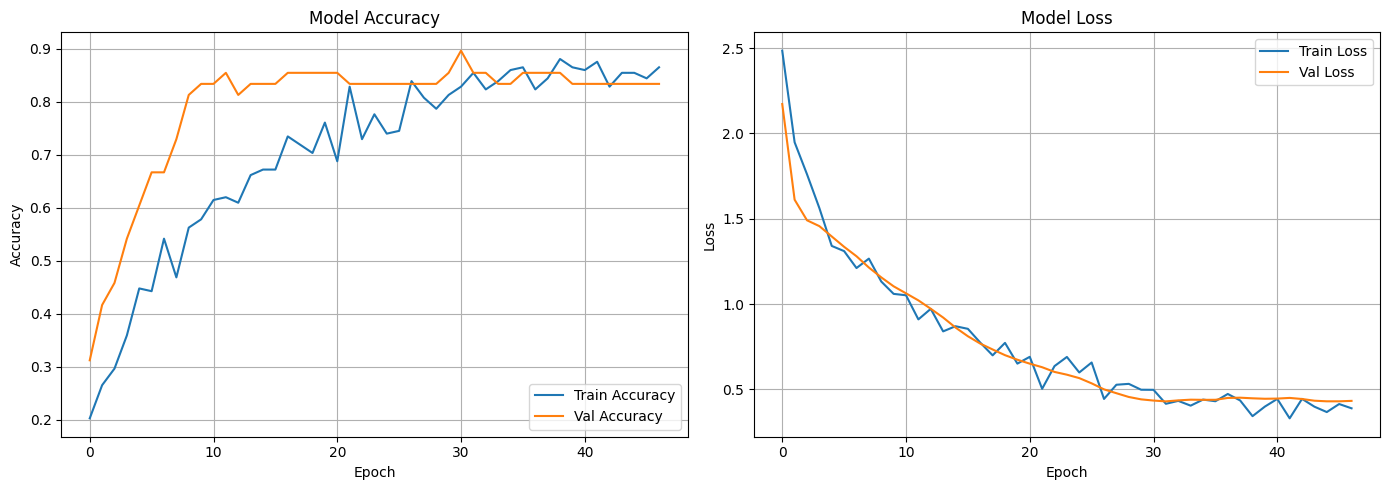

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. Ewaluacja na zbiorze testowym

In [9]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Dokładność
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

class_names = ['alohomora', 'lumos', 'wingardium', 'avada', 'mystery']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9836 - loss: 0.2067

Test Accuracy: 0.9836
Test Loss: 0.2067

Classification Report:
              precision    recall  f1-score   support

   alohomora       1.00      1.00      1.00        12
       lumos       1.00      0.92      0.96        12
  wingardium       1.00      1.00      1.00        12
       avada       1.00      1.00      1.00        12
     mystery       0.93      1.00      0.96        13

    accuracy                           0.98        61
   macro avg       0.99      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



## 10. Confusion Matrix

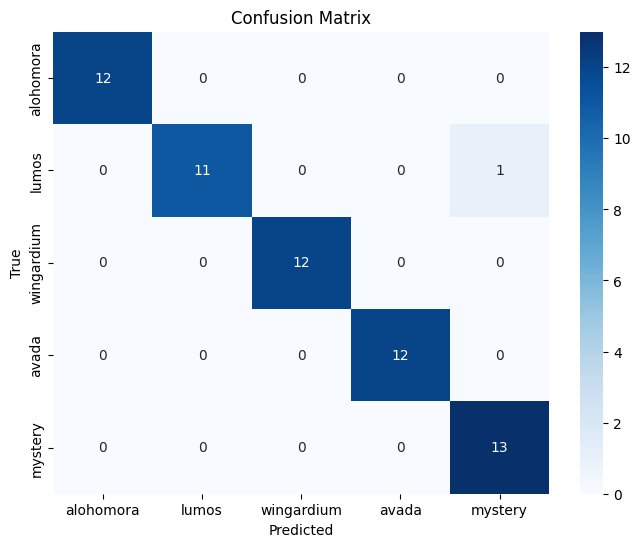

In [10]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 11. Zapis modelu

In [11]:
# Zapis modelu w formacie Keras (.h5)
model.save('gesture_model_cnn.h5')
print("Model zapisany jako gesture_model_cnn.h5")

# Zapis również w nowym formacie Keras 3 (.keras)
model.save('gesture_model_cnn.keras')
print("Model zapisany jako gesture_model_cnn.keras")

Model zapisany jako gesture_model_cnn.h5
Model zapisany jako gesture_model_cnn.keras


## 12. Konwersja do TensorFlow Lite (dla microcontrollerów)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# KWANTYZACJA INT8 - drastycznie zmniejsza rozmiar modelu (4x mniej)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Funkcja reprezentatywna dla kwantyzacji (próbki danych treningowych)
def representative_dataset():
    for i in range(100):
        # Wybierz losową próbkę z danych treningowych
        idx = np.random.randint(0, len(X_train))
        sample = X_train[idx:idx+1].astype(np.float32)
        yield [sample]

converter.representative_dataset = representative_dataset

# Wymuszenie pełnej kwantyzacji INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Konwersja
tflite_model_quant = converter.convert()

# Zapis skwantyzowanego modelu
with open('gesture_model_cnn.tflite', 'wb') as f:
    f.write(tflite_model_quant)

print(f"TFLite model (INT8 quantized) zapisany: {len(tflite_model_quant):,} bajtów")
print(f"Rozmiar: {len(tflite_model_quant) / 1024:.1f} KB")
print(f"Model zmieści się w Arduino Nano 33 BLE Sense (1MB flash): {'TAK' if len(tflite_model_quant) < 1024*1024 else 'NIE'}")

# Konwersja do C array (dla Arduino)
def convert_to_c_array(tflite_model, output_file='model.h'):
    """Konwertuje model TFLite do tablicy C dla Arduino"""
    
    c_str = '#ifndef MODEL_H\n'
    c_str += '#define MODEL_H\n\n'
    c_str += '// Model size: ' + str(len(tflite_model)) + ' bytes\n'
    c_str += '// Quantized to INT8 for Arduino Nano 33 BLE Sense\n\n'
    c_str += 'const unsigned char model_tflite[] = {\n  '
    
    hex_array = [f'0x{byte:02x}' for byte in tflite_model]
    
    # Formatuj po 12 elementów w linii
    for i, hex_val in enumerate(hex_array):
        c_str += hex_val
        if i < len(hex_array) - 1:
            c_str += ', '
        if (i + 1) % 12 == 0:
            c_str += '\n  '
    
    c_str += '\n};\n'
    c_str += f'const unsigned int model_tflite_len = {len(tflite_model)};\n\n'
    c_str += '#endif\n'
    
    with open(output_file, 'w') as f:
        f.write(c_str)
    
    print(f"C header zapisany jako: {output_file}")

# Generuj plik .h dla Arduino
convert_to_c_array(tflite_model_quant, 'gesture_model_cnn.h')

INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpujfwrbxy\assets


INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpujfwrbxy\assets


Saved artifact at 'C:\Users\Olek\AppData\Local\Temp\tmpujfwrbxy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  3048893387728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893388304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893389840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893390800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893390608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893390416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893391184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893390992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893390032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3048893389072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  30488933888

c:\Users\Olek\.platformio\penv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## 13. Test pojedynczej predykcji

In [13]:
sample_idx = 0
sample = X_test[sample_idx:sample_idx+1]
true_label = y_test[sample_idx]
print(sample)
prediction = model.predict(sample, verbose=0)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prawdziwa klasa: {class_names[true_label]}")
print(f"Przewidziana klasa: {class_names[predicted_class]}")
print(f"Pewność: {confidence:.2%}")
print(f"\nWszystkie prawdopodobieństwa:")
for i, prob in enumerate(prediction[0]):
    print(f"  {class_names[i]}: {prob:.2%}")

[[[-1.400e-01  1.700e-01 -8.900e-01  1.550e+01  1.950e+00  4.210e+00]
  [ 2.000e-02  1.700e-01 -7.700e-01  1.709e+01 -1.508e+01  5.800e+00]
  [-3.000e-02  1.400e-01 -7.700e-01  2.167e+01 -1.404e+01  2.400e-01]
  [-3.000e-02  1.400e-01 -7.800e-01  2.380e+01 -1.770e+01 -1.800e-01]
  [-4.000e-02  1.400e-01 -8.300e-01  2.722e+01 -1.459e+01 -9.800e-01]
  [-4.000e-02  1.400e-01 -8.500e-01  2.795e+01 -9.340e+00 -3.100e-01]
  [-4.000e-02  1.200e-01 -8.300e-01  2.795e+01  4.880e+00  9.200e-01]
  [-4.000e-02  1.100e-01 -8.200e-01  2.814e+01  1.184e+01  1.340e+00]
  [-8.000e-02  9.000e-02 -8.000e-01  2.838e+01  1.825e+01  2.870e+00]
  [-1.000e-01  9.000e-02 -7.700e-01  2.856e+01  1.636e+01  5.550e+00]
  [-9.000e-02  9.000e-02 -7.500e-01  2.887e+01  1.282e+01  6.710e+00]
  [-8.000e-02  9.000e-02 -7.600e-01  3.137e+01  3.050e+00  6.410e+00]
  [-8.000e-02  9.000e-02 -7.700e-01  3.308e+01 -1.950e+00  5.370e+00]
  [-1.000e-01  9.000e-02 -8.100e-01  3.625e+01 -6.040e+00  2.690e+00]
  [-1.400e-01  9.000